# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [2]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.fc1 = torch.nn.Linear(in_features=16 * 5 * 5, out_features=120)
    self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
    self.fc3 = torch.nn.Linear(in_features=84, out_features=10)

  def forward(self, x):

    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

### Define cost function

In [3]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [4]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [5]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [6]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [14]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):

  train_loader, val_loader, test_loader = get_data(batch_size)

  # Initialize the network
  net = LeNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device=device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device=device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device=device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function, device=device)
    val_loss, val_accuracy = test(net, val_loader, cost_function, device=device)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device=device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device=device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device=device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [ ]:
main(device='cpu')
# If you have a GPU, you can change the device to 'cuda:0' or similar

Before training:
	 Training loss 0.01805, Training accuracy 9.62
	 Validation loss 0.00907, Validation accuracy 9.91
	 Test loss 0.00922, Test accuracy 9.42
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00968, Training accuracy 61.14
	 Validation loss 0.00086, Validation accuracy 93.27
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00109, Training accuracy 95.64
	 Validation loss 0.00045, Validation accuracy 96.42
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00067, Training accuracy 97.32
	 Validation loss 0.00033, Validation accuracy 97.36
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00051, Training accuracy 97.95
	 Validation loss 0.00028, Validation accuracy 97.82
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00042, Training accuracy 98.28
	 Validation loss 0.00026, Validation accuracy 97.96
------------------

Check which MNIST digit is most frequently confused with which other digit (e.g. plot a confusion matrix). Can you explain why?



In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

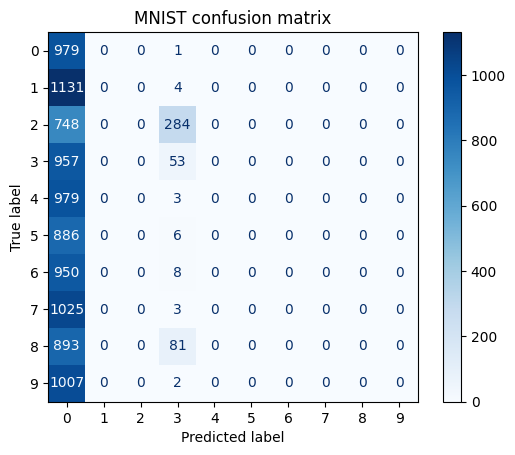

array([[ 979,    0,    0,    1,    0,    0,    0,    0,    0,    0],
       [1131,    0,    0,    4,    0,    0,    0,    0,    0,    0],
       [ 748,    0,    0,  284,    0,    0,    0,    0,    0,    0],
       [ 957,    0,    0,   53,    0,    0,    0,    0,    0,    0],
       [ 979,    0,    0,    3,    0,    0,    0,    0,    0,    0],
       [ 886,    0,    0,    6,    0,    0,    0,    0,    0,    0],
       [ 950,    0,    0,    8,    0,    0,    0,    0,    0,    0],
       [1025,    0,    0,    3,    0,    0,    0,    0,    0,    0],
       [ 893,    0,    0,   81,    0,    0,    0,    0,    0,    0],
       [1007,    0,    0,    2,    0,    0,    0,    0,    0,    0]])

In [22]:
def plot_confusion_matrix(net, data_loader, device='cpu'):
    net.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = net(inputs)
            _, preds = outputs.max(1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("MNIST confusion matrix")
    plt.show()
    return cm

net = LeNet().to('cpu')
net.eval()
train_loader, val_loader, test_loader = get_data(batch_size=128)
plot_confusion_matrix(net, test_loader, device='cpu')
# if you have a GPU, you can change the device to 'cuda:0' or similar

The LeNet5 architecture can also be implemented using the sequential API ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [69]:
LeNet5_sequentialAPI = torch.nn.Sequential(
    torch.nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2),   # conv1
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),  # conv2
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    torch.nn.Flatten(),  # flatten for fully connected layers

    torch.nn.Linear(16 * 6 * 6, 120),  # fc1
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),          # fc2
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)            # fc3 (output)
)

##Experiments

* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.


In [70]:
def train_with_early_stopping(net, train_loader, val_loader, optimizer, cost_function, device='cpu', epochs=50, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    for e in range(epochs):
        train_loss, train_acc = train(net, train_loader, optimizer, cost_function, device=device)
        val_loss, val_acc = test(net, val_loader, cost_function, device=device)
        print(f"Epoch {e+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = net.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {e+1}")
                net.load_state_dict(best_state)
                break
    return net

In [ ]:
net = LeNet5_sequentialAPI
optimizer = get_optimizer(net, lr=0.01, wd=0.000001, momentum=0.9)
model = train_with_early_stopping(
    net=net,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    cost_function=get_cost_function(),
    device='cpu',
    epochs=50,
    patience=5
)
# If you have a GPU, you can change the device to 'cuda:0' or similar

Epoch 1: train_loss=0.0173, val_loss=0.0077
Epoch 2: train_loss=0.0142, val_loss=0.0064
Epoch 3: train_loss=0.0122, val_loss=0.0060
Epoch 4: train_loss=0.0112, val_loss=0.0055
Epoch 5: train_loss=0.0103, val_loss=0.0051
Epoch 6: train_loss=0.0095, val_loss=0.0052
Epoch 7: train_loss=0.0090, val_loss=0.0048
Epoch 8: train_loss=0.0085, val_loss=0.0046
Epoch 9: train_loss=0.0080, val_loss=0.0046
Epoch 10: train_loss=0.0075, val_loss=0.0048
Epoch 11: train_loss=0.0071, val_loss=0.0045
Epoch 12: train_loss=0.0067, val_loss=0.0045
Epoch 13: train_loss=0.0063, val_loss=0.0044
Epoch 14: train_loss=0.0060, val_loss=0.0045
Epoch 15: train_loss=0.0055, val_loss=0.0045
Epoch 16: train_loss=0.0052, val_loss=0.0047
Epoch 17: train_loss=0.0048, val_loss=0.0049
Epoch 18: train_loss=0.0045, val_loss=0.0050
Early stopping at epoch 18


In [72]:
def get_data_cifar10(batch_size, test_batch_size=256):
    transform = [
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
    transform = T.Compose(transform)
    train_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
    test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)
    num_samples = len(train_data)
    training_samples = int(num_samples*0.5+1)
    validation_samples = num_samples - training_samples
    training_data, validation_data = torch.utils.data.random_split(train_data, [training_samples, validation_samples])
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [73]:
train_loader, val_loader, test_loader = get_data_cifar10(batch_size=128)

In [81]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         patience=5):

  train_loader, val_loader, test_loader = get_data_cifar10(batch_size)

  # Initialize the network
  net = LeNet5_sequentialAPI

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device=device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device=device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device=device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # Use early stopping for training
  train_with_early_stopping(
      net=net,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      cost_function=cost_function,
      device=device,
      epochs=epochs,
      patience=patience
  )

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device=device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device=device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device=device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [ ]:
main(device='cpu')
# If you have a GPU, you can change the device to 'cuda:0' or similar

Before training:
	 Training loss 0.01405, Training accuracy 80.34
	 Validation loss 0.00695, Validation accuracy 80.62
	 Test loss 0.01594, Test accuracy 59.75
-----------------------------------------------------
Epoch 1: train_loss=0.0081, val_loss=0.0034
Epoch 2: train_loss=0.0049, val_loss=0.0032
Epoch 3: train_loss=0.0039, val_loss=0.0032
Epoch 4: train_loss=0.0032, val_loss=0.0033
Epoch 5: train_loss=0.0026, val_loss=0.0035
Epoch 6: train_loss=0.0022, val_loss=0.0037
Epoch 7: train_loss=0.0018, val_loss=0.0040
Epoch 8: train_loss=0.0014, val_loss=0.0044
Early stopping at epoch 8
After training:
	 Training loss 0.00117, Training accuracy 95.35
	 Validation loss 0.00442, Validation accuracy 75.34
	 Test loss 0.00825, Test accuracy 61.40
-----------------------------------------------------


In [85]:
def get_data_cifar10_augmented(batch_size, test_batch_size=256):
    transform_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
    test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
    num_samples = len(train_data)
    training_samples = int(num_samples*0.5+1)
    validation_samples = num_samples - training_samples
    training_data, validation_data = torch.utils.data.random_split(train_data, [training_samples, validation_samples])
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [91]:
class LeNetDropout(torch.nn.Module):
    def __init__(self):
        super(LeNetDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5, 1, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5, 1, 0)
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, 2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [92]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         patience=5):

  train_loader, val_loader, test_loader = get_data_cifar10_augmented(batch_size)

  # Initialize the network
  net = LeNetDropout().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device=device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device=device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device=device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # Use early stopping for training
  train_with_early_stopping(
      net=net,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      cost_function=cost_function,
      device=device,
      epochs=epochs,
      patience=patience
  )

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device=device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device=device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device=device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [93]:
main(device='cpu')
# If you have a GPU, you can change the device to 'cuda:0' or similar

Before training:
	 Training loss 0.01806, Training accuracy 8.04
	 Validation loss 0.00903, Validation accuracy 8.08
	 Test loss 0.00922, Test accuracy 7.69
-----------------------------------------------------
Epoch 1: train_loss=0.0175, val_loss=0.0081
Epoch 2: train_loss=0.0159, val_loss=0.0074
Epoch 3: train_loss=0.0149, val_loss=0.0070
Epoch 4: train_loss=0.0142, val_loss=0.0066
Epoch 5: train_loss=0.0138, val_loss=0.0064
Epoch 6: train_loss=0.0134, val_loss=0.0063
Epoch 7: train_loss=0.0130, val_loss=0.0060
Epoch 8: train_loss=0.0129, val_loss=0.0060
Epoch 9: train_loss=0.0127, val_loss=0.0059
Epoch 10: train_loss=0.0124, val_loss=0.0057
Epoch 11: train_loss=0.0121, val_loss=0.0057
Epoch 12: train_loss=0.0120, val_loss=0.0055
Epoch 13: train_loss=0.0118, val_loss=0.0055
Epoch 14: train_loss=0.0118, val_loss=0.0055
Epoch 15: train_loss=0.0116, val_loss=0.0056
Epoch 16: train_loss=0.0115, val_loss=0.0052
Epoch 17: train_loss=0.0113, val_loss=0.0052
Epoch 18: train_loss=0.0113, val_

In [94]:
from torchvision.models import resnet18

In [96]:
def get_resnet18(num_classes=10):
    model = resnet18(num_classes=num_classes)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model